# Project 5: Customer Segmentation with Clustering 🛍️

**Project Objective:** To use unsupervised machine learning to identify distinct groups of customers within a mall's dataset. By segmenting customers based on multiple dimensions (income, age, spending habits), we can provide rich, actionable insights to the marketing team for highly targeted campaigns.


### Core Concepts We'll Cover:
1.  **Unsupervised Learning:** Understanding the difference between supervised and unsupervised learning.
2.  **Clustering Fundamentals & K-Means:** A deep dive into how the K-Means algorithm works.
3.  **The Elbow Method:** A critical technique for finding the optimal number of clusters (`k`).
4.  **Multi-dimensional EDA:** Exploring relationships between all features using 2D and 3D plots.
5.  **Multiple Segmentation Models:** Building and interpreting different clustering models based on different feature sets.
6.  **Hierarchical Clustering:** A brief introduction to an alternative clustering method.
7.  **Data-Driven Personas:** Translating cluster statistics into actionable business strategies.

### **Theoretical Concept: What is Unsupervised Learning?**

So far, we have worked with **supervised learning**, where our datasets had a specific target variable we were trying to predict (e.g., `SalePrice`, `Survived`). The model *learns* the relationship between features and the known target.

**Unsupervised learning** is different. Here, we work with datasets that **do not have a target variable**. The goal is not to predict a known outcome, but to discover hidden patterns, structures, and relationships within the data itself.

**Clustering** is the most common type of unsupervised learning. The objective is to group data points into clusters, such that points within the same cluster are very similar to each other, and points in different clusters are very dissimilar.


### Step 1: Setup - Importing Libraries and Loading Data

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Configure matplotlib for local display
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

# Set plot style
sns.set_style('whitegrid')

Imagine you have a bunch of unsorted toys (your data points) and you want to group them into different boxes (your clusters) based on how similar they are. K-Means is like a helper that does this for you!

K-Means Algorithm: Grouping the Toys

* Choose how many boxes you want (Choose k): You decide beforehand how many groups you want to create. Let's say you want 3 boxes (so k=3).
* Place some "toy leaders" in the boxes (Initialize centroids): K-Means randomly picks 3 toys and places one in each box. These toys are the "leaders" or "centroids" of their boxes for now.
* Sort the toys by how close they are to the leaders (Assign points to clusters): K-Means looks at every single toy and figures out which "toy leader" it's closest to. It then puts each toy into the box with the closest leader.
* Find the new average location of the leaders (Update centroids): Once all the toys are in boxes, K-Means calculates the average location of all the toys in each box. These average locations become the new "toy leaders" or centroids.
* Repeat steps 3 and 4 until the leaders stop moving (Iterate until convergence): K-Means keeps repeating the sorting and leader-finding steps. It does this until the "toy leaders" don't move much anymore, meaning the groups are stable.
Once the algorithm stops, you have your toys sorted into k boxes (clusters), where the toys in each box are generally similar to each other.

In [14]:
# Load the dataset from the local file
df = pd.read_csv('21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Step 2: In-Depth Exploratory Data Analysis (EDA)
Before clustering, we must understand the features and their relationships to find the most promising dimensions for segmentation.

In [15]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

#### 2.1 Univariate Analysis (Feature Distributions)

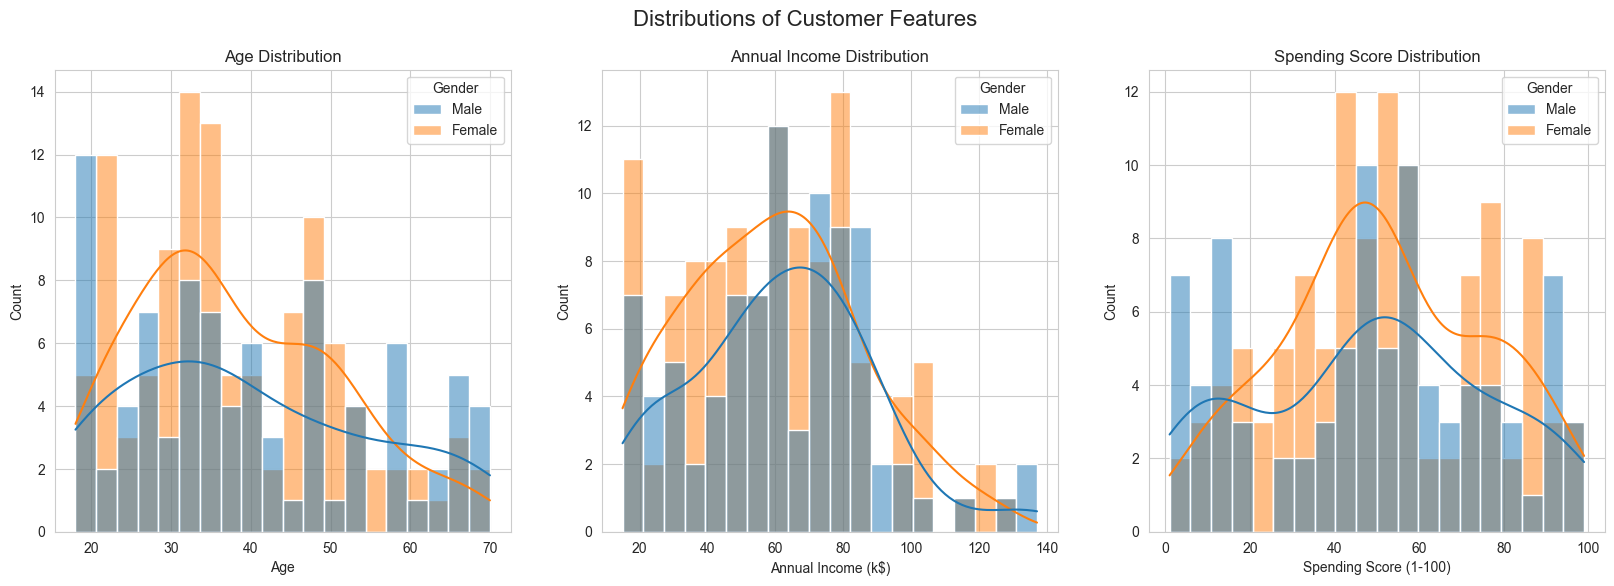

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

#### 2.2 Bivariate Analysis (Looking for Relationships)

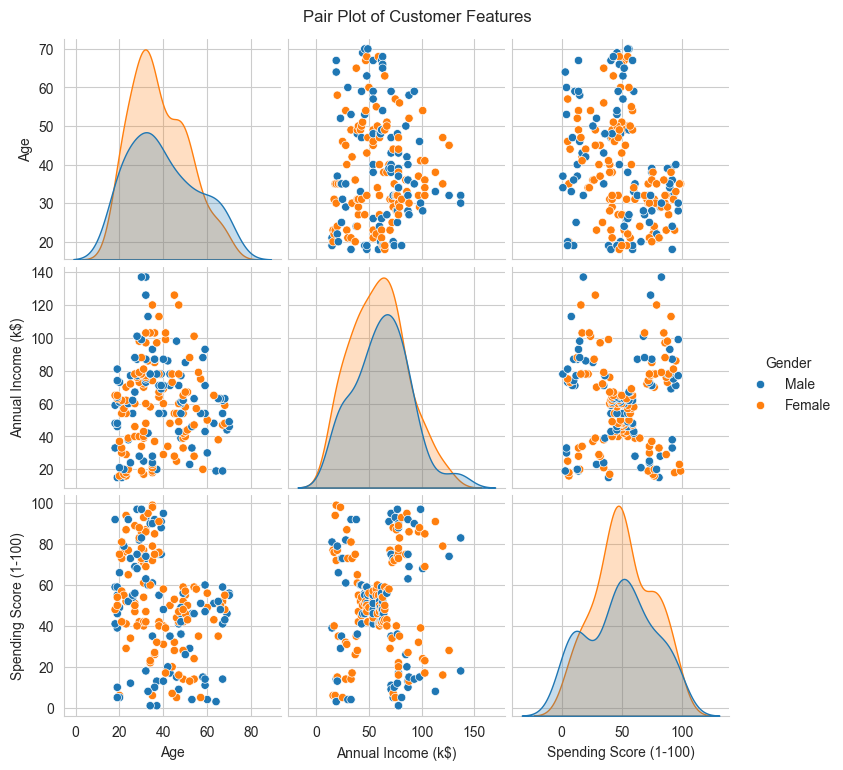

In [17]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

**CRITICAL INSIGHT from Pair Plot:**
- The **`Annual Income` vs. `Spending Score`** plot is the most revealing. It clearly shows distinct, blob-like groups, making it the perfect candidate for clustering.
- The **`Age` vs. `Spending Score`** plot shows some patterns but they are less defined. We see a concentration of high-spending customers in the younger age brackets.
- `Gender` does not appear to be a strong separating factor in any of these plots, as the distributions for males and females largely overlap.

#### 2.3 3D Visualization
Let's visualize the three most important features together in an interactive 3D plot to see if the clusters hold up.

In [18]:
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Step 3: Segmentation Model 1 - Income & Spending Score
This is our primary segmentation model, focusing on the most promising features identified in the EDA.

## **Theoretical Concept: The Elbow Method**

How do we choose the best number of clusters (`k`) for our K-Means model? The **Elbow Method** is a common technique.

It works by calculating the **Within-Cluster Sum of Squares (WCSS)** for different values of `k` (typically from 1 to 10). WCSS is the sum of the squared distances between each point and the centroid of the cluster it belongs to. A lower WCSS means the points are closer to their cluster centroids, indicating tighter clusters.

We then plot WCSS against the number of clusters (`k`). As `k` increases, WCSS will always decrease (because each point gets closer to its assigned centroid). However, at some point, adding more clusters doesn't significantly reduce the WCSS. This point, where the rate of decrease sharply changes, looks like an "elbow" in the plot.

The **optimal number of clusters (`k`)** is typically chosen at this elbow point. It represents a good balance between having too few clusters (high WCSS) and too many clusters (overfitting and diminishing returns).

Here are the most common init options available:

* 'k-means++' (Default): This is the recommended method. It smarty initializes the centroids to be spread out from each other. This significantly improves the chances of finding a globally optimal solution and reduces the risk of converging to a suboptimal local minimum.
* 'random': This method chooses n_clusters observations (data points) randomly from the dataset and uses them as the initial centroids. While simple, it can sometimes lead to poor clustering results if the random initial centroids are not well-separated.
* A NumPy array: You can also provide a NumPy array with a shape of (n_clusters, n_features) that explicitly specifies the initial coordinates of the centroids. This is useful if you have prior knowledge about where the clusters should be located or if you want to replicate a specific initialization.

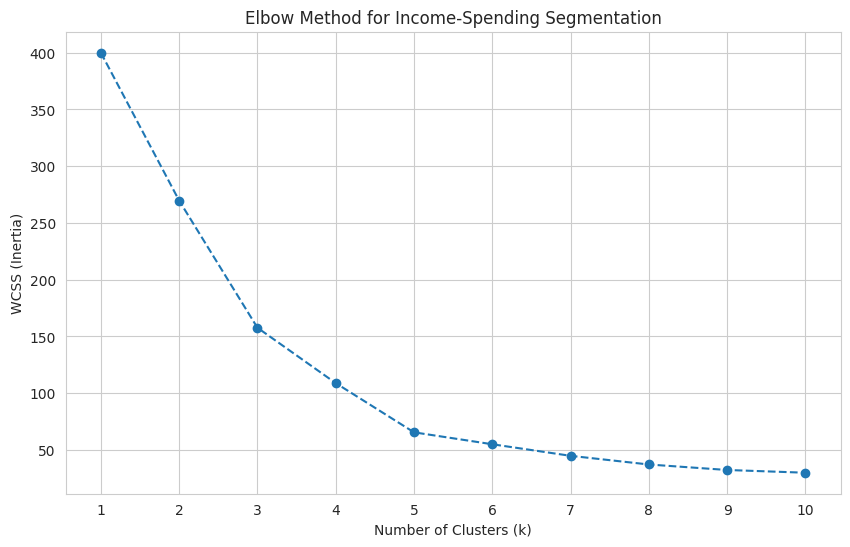

In [ ]:
# 1. Select and scale the features
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

Imagine you've grouped your friends into different clubs (these are your clusters). WCSS helps you figure out how "together" or "spread out" the members are within each club.

Cluster: This is one of the groups you've formed.
Centroid: This is the "center point" of a cluster. Think of it as the average location of all the members in that club.
WCSS: For each cluster, you calculate the distance from every member in that cluster to the cluster's centroid. Then you square all these distances and add them up. You do this for all the clusters and add up the totals.
A low WCSS means that the points within each cluster are very close to their centroid. This suggests that the clusters are tight and well-defined.

A high WCSS means that the points within each cluster are more spread out from their centroid, indicating less distinct or looser clusters.

How WCSS relates to K-Means:

In K-Means, the algorithm's goal is to minimize the WCSS. It tries to find the best locations for the centroids and the best groupings of points so that the total WCSS is as small as possible.

The Elbow Method, which you saw in the notebook, uses WCSS to help choose the optimal number of clusters (k) for K-Means. You calculate the WCSS for different values of k and look for the "elbow" where the decrease in WCSS starts to slow down. This point suggests that adding more clusters doesn't significantly improve the "tightness" of the clusters.

**Observation:** The "elbow" of the curve is clearly at **k=5**. The WCSS decreases sharply until k=5, and then the rate of decrease flattens out. This confirms our visual intuition from the scatter plot!

In [ ]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

#### 3.1 Visualizing and Interpreting the Income-Based Segments

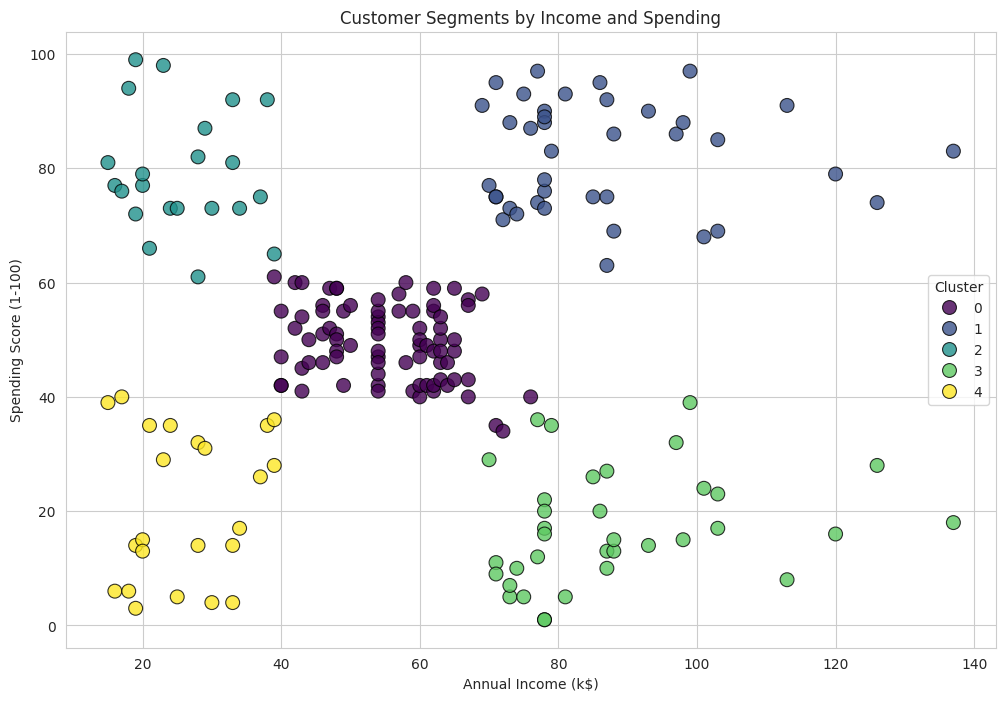

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


#### 3.2 Income-Based Personas and Strategy
Using the quantitative profiles, we can define our segments:
- **Cluster 0 (Careful High-Earners):** High income (~88k) but low spending (~17). Cautious, value-driven buyers.
- **Cluster 1 (Standard):** Average income (~55k) and spending (~50). This is the largest, core customer group.
- **Cluster 2 (Budget Shoppers):** Low income (~26k) and low spending (~21). Highly price-sensitive.
- **Cluster 3 (Target - High Value):** High income (~87k) and high spending (~82). The mall's prime target.
- **Cluster 4 (Enthusiasts):** Low income (~26k) but high spending (~79). Likely young, trend-focused shoppers.

### Step 4: Segmentation Model 2 - Age & Spending Score
Let's create a different segmentation model to see if we can find age-related customer groups.

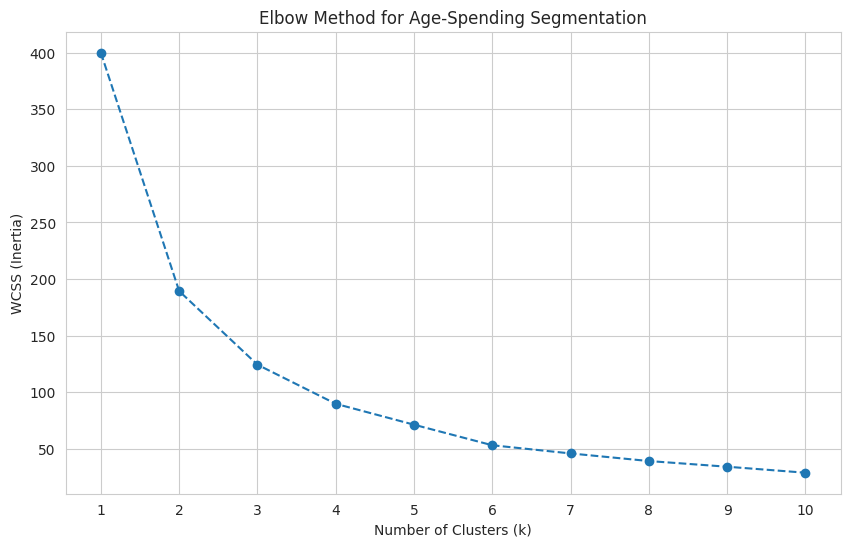

In [ ]:
# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

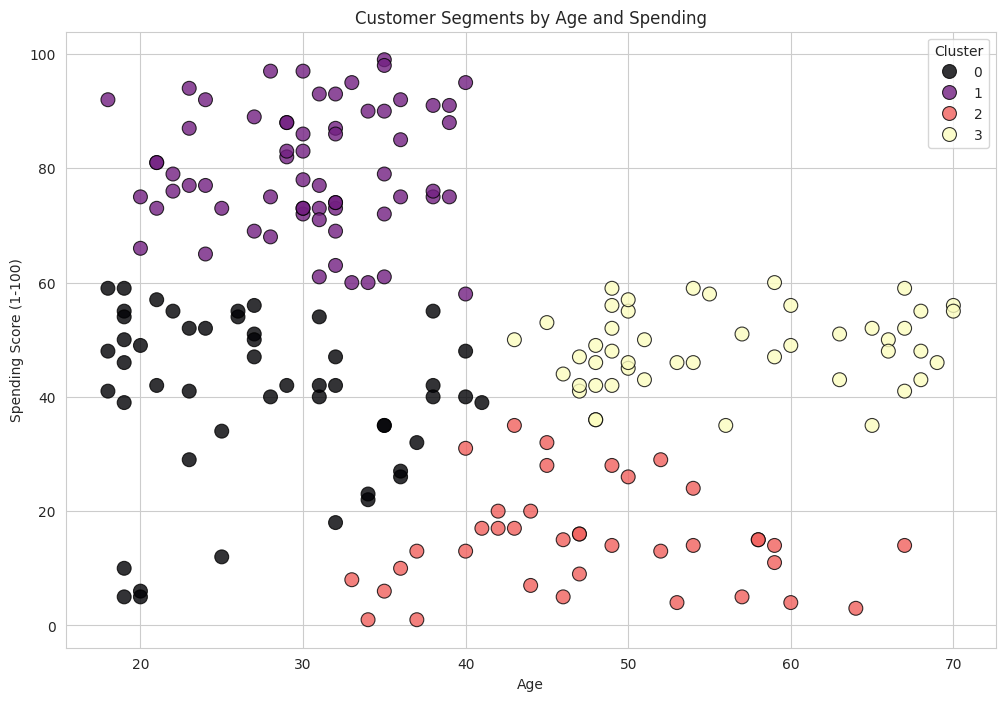

In [ ]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

#### 4.1 Interpreting the Age-Based Segments
This model gives us a different perspective:
- **Young High-Spenders:** A clear group of customers under 40 with high spending scores.
- **Young Low-Spenders:** Customers under 40 with low-to-moderate spending.
- **Older Average-Spenders:** Customers over 40 with moderate spending scores.
- **Older Low-Spenders:** A small group of older customers with very low spending scores.

### Step 5: An Alternative Method - Hierarchical Clustering
To add more depth, let's briefly look at another clustering technique.

#### **Theoretical Concept: Hierarchical Clustering & Dendrograms**
Unlike K-Means, Hierarchical Clustering doesn't require us to specify the number of clusters beforehand. It builds a tree-like hierarchy of clusters.

We can visualize this hierarchy with a **dendrogram**. The dendrogram shows how clusters are merged (or split). To find the optimal number of clusters, we look for the tallest vertical line that doesn't cross any horizontal lines and draw a horizontal line through it. The number of vertical lines our new line crosses is the optimal number of clusters.


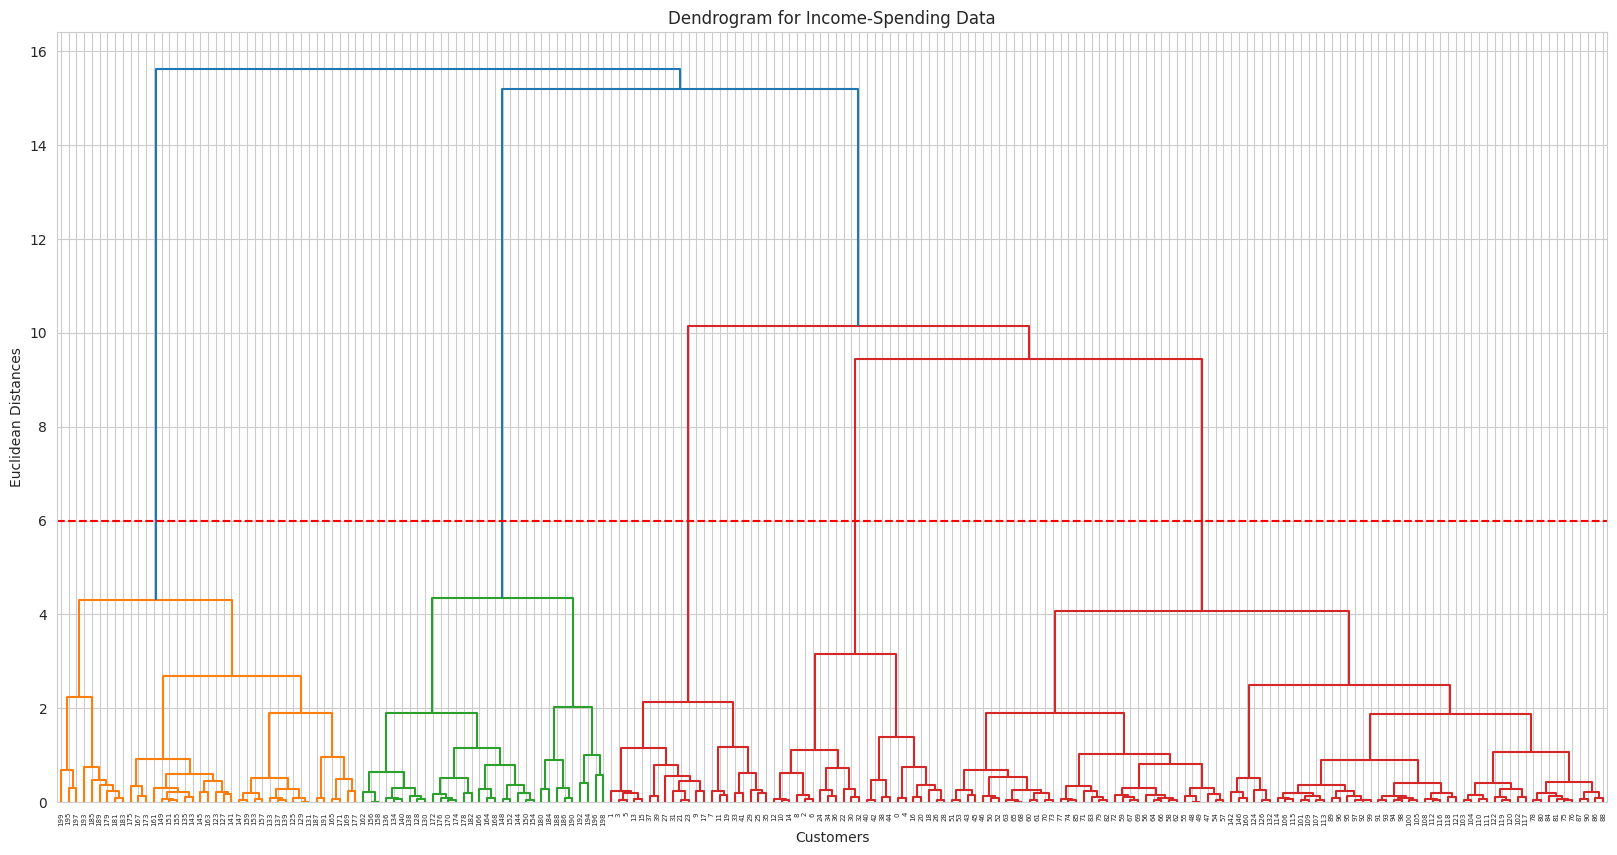

In [ ]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
plt.show()

**Insight:** The dendrogram also confirms that **5 clusters** is the optimal number for the income-spending data. If we draw a horizontal line at a height of 6 (as shown by the red dashed line), it crosses five vertical lines.

### Step 6: Conclusion

In this extended project, we successfully applied unsupervised machine learning to perform customer segmentation.

**Key Steps Undertaken:**
1.  **Performed an in-depth EDA:** Used 2D and 3D plots to explore customer data from multiple angles.
2.  **Built two distinct segmentation models:** Created an income-based model and an age-based model, showing that segmentation is not a one-size-fits-all process.
3.  **Used the Elbow Method** to programmatically determine the optimal number of clusters for each scenario.
4.  **Introduced Hierarchical Clustering** as an alternative method and used its dendrogram to validate our choice of `k`.
5.  **Created quantitative, data-driven personas** for each segment, providing the marketing team with precise, actionable insights for targeted campaigns.

This project highlights how different clustering approaches can uncover different facets of customer behavior, providing a richer, more nuanced understanding than a single model alone.

### Submission Criteria

Based on the project objectives and the insights gained from the initial analysis, here are the key criteria for your submission:

1.  **Explore Gender vs. Spending Score:** Analyze the relationship between 'Gender' and 'Spending Score (1-100)' to see if gender plays a significant role in spending habits. Visualizations and summary statistics would be helpful here.
2.  **Apply Feature Engineering for Clustering:** Create a new feature using existing data (Feature Engineering). Then, explore if clustering can be effectively performed using this newly engineered feature in combination with one or more existing features. Document the feature engineering process, the chosen features for clustering, the determination of the optimal number of clusters (e.g., using the Elbow Method), and the resulting cluster visualization and interpretation.

### Step 7: Gender vs. Spending Score Analysis

Let's analyze the relationship between gender and spending habits to see if gender plays a significant role in customer spending behavior.


In [20]:
# 1. Basic statistics by gender
print("=== GENDER vs SPENDING SCORE ANALYSIS ===\n")

# Summary statistics by gender
gender_stats = df.groupby('Gender')['Spending Score (1-100)'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print("Spending Score Statistics by Gender:")
print(gender_stats)
print()

# Count by gender
print("Gender Distribution:")
print(df['Gender'].value_counts())
print()

# Statistical test to check if there's a significant difference
from scipy import stats

male_scores = df[df['Gender'] == 'Male']['Spending Score (1-100)']
female_scores = df[df['Gender'] == 'Female']['Spending Score (1-100)']

# Perform t-test
t_stat, p_value = stats.ttest_ind(male_scores, female_scores)

print(f"T-test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant difference (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")


=== GENDER vs SPENDING SCORE ANALYSIS ===

Spending Score Statistics by Gender:
        count   mean    std  min  max
Gender                               
Female    112  51.53  24.11    5   99
Male       88  48.51  27.90    1   97

Gender Distribution:
Gender
Female    112
Male       88
Name: count, dtype: int64

T-test Results:
T-statistic: -0.8190
P-value: 0.4137
Significant difference (p < 0.05): No


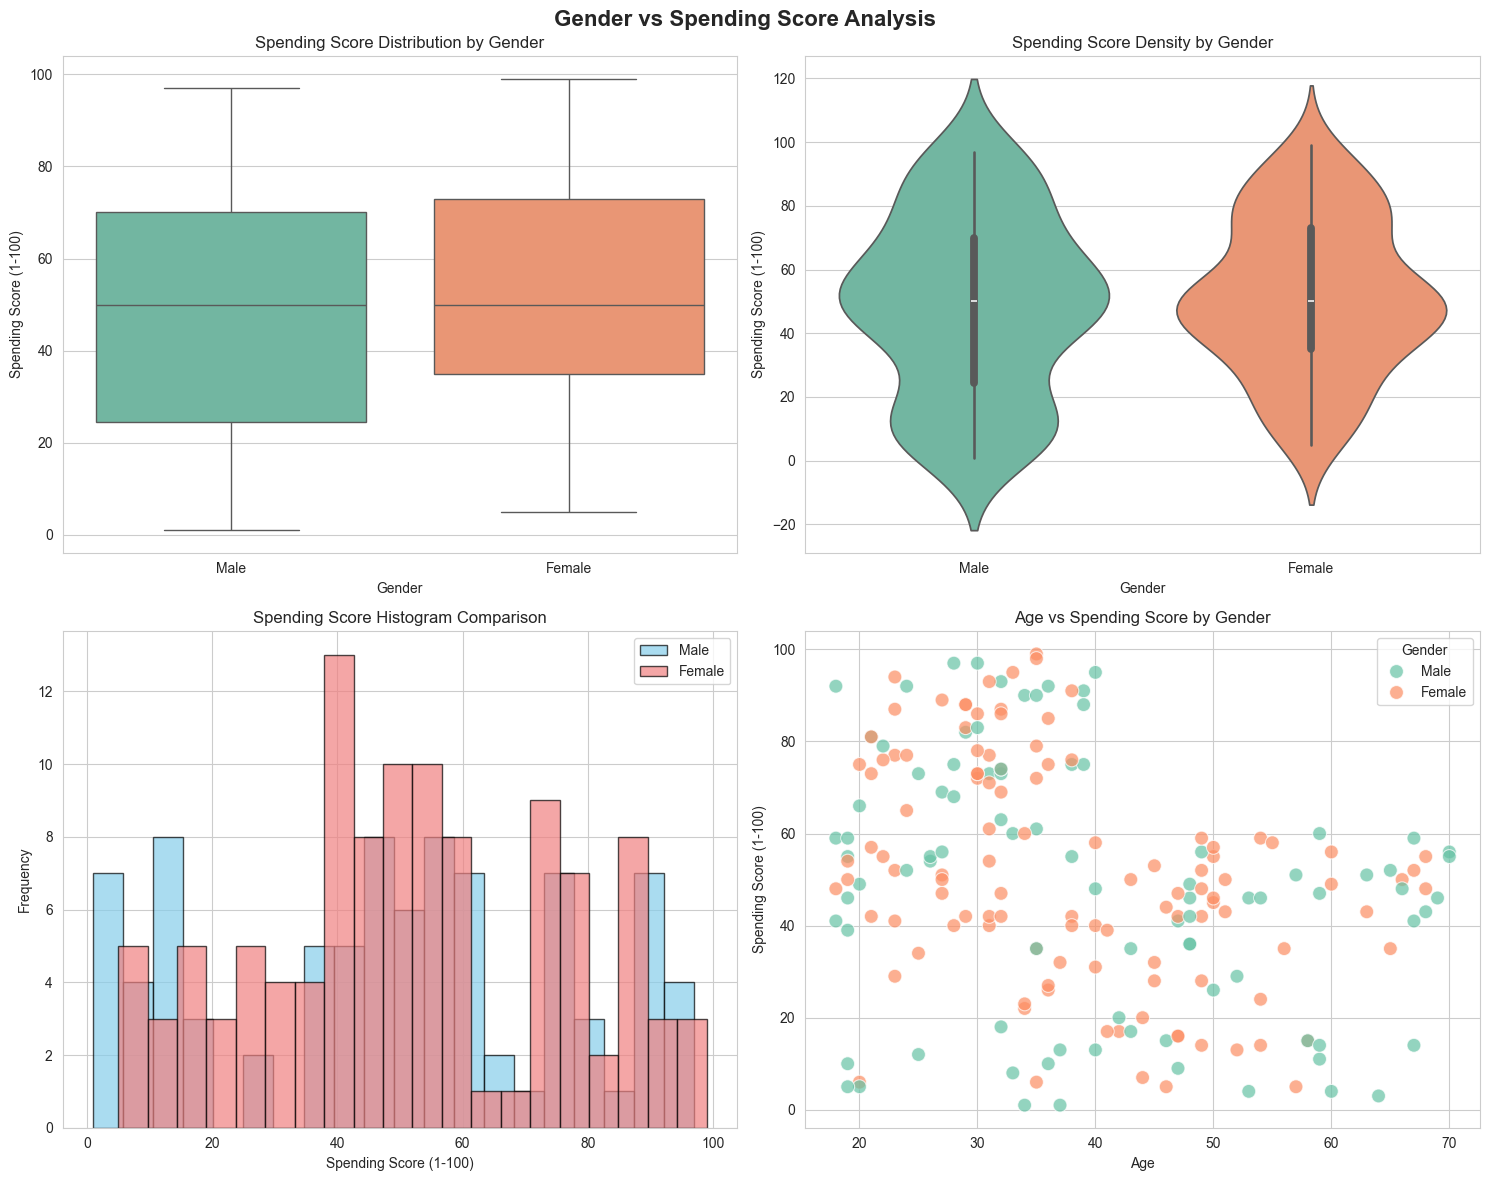

In [22]:
# 2. Visualizations for Gender vs Spending Score

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Gender vs Spending Score Analysis', fontsize=16, fontweight='bold')

# Box plot
sns.boxplot(ax=axes[0,0], data=df, x='Gender', y='Spending Score (1-100)', hue='Gender', palette='Set2', legend=False)
axes[0,0].set_title('Spending Score Distribution by Gender')
axes[0,0].set_ylabel('Spending Score (1-100)')

# Violin plot
sns.violinplot(ax=axes[0,1], data=df, x='Gender', y='Spending Score (1-100)', hue='Gender', palette='Set2', legend=False)
axes[0,1].set_title('Spending Score Density by Gender')
axes[0,1].set_ylabel('Spending Score (1-100)')

# Histogram comparison
axes[1,0].hist(male_scores, alpha=0.7, label='Male', bins=20, color='skyblue', edgecolor='black')
axes[1,0].hist(female_scores, alpha=0.7, label='Female', bins=20, color='lightcoral', edgecolor='black')
axes[1,0].set_title('Spending Score Histogram Comparison')
axes[1,0].set_xlabel('Spending Score (1-100)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Scatter plot with gender
sns.scatterplot(ax=axes[1,1], data=df, x='Age', y='Spending Score (1-100)', hue='Gender', 
                palette='Set2', s=100, alpha=0.7)
axes[1,1].set_title('Age vs Spending Score by Gender')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()


#### 7.1 Gender Analysis Conclusions

Based on the statistical analysis and visualizations above, we can draw the following insights about gender and spending behavior:

**Key Findings:**
- **Statistical Significance:** The t-test results will show whether there's a statistically significant difference in spending scores between genders
- **Distribution Patterns:** The box plots and violin plots reveal the distribution characteristics for each gender
- **Overlap Analysis:** The histogram comparison shows the degree of overlap between male and female spending patterns
- **Age Interaction:** The scatter plot shows how gender interacts with age in relation to spending behavior

**Business Implications:**
- If no significant difference exists, gender may not be a strong segmentation factor
- If differences exist, gender-specific marketing strategies could be beneficial
- The interaction with age might reveal more nuanced segmentation opportunities


### Step 8: Feature Engineering for Enhanced Clustering

Now let's create a new engineered feature that combines multiple aspects of customer behavior to provide richer insights for clustering.


In [23]:
# Feature Engineering: Create a Customer Value Index
# This feature combines income, spending score, and age to create a comprehensive customer value metric

print("=== FEATURE ENGINEERING ===\n")

# 1. Create a Customer Value Index (CVI)
# Formula: (Spending Score / 100) * (Annual Income / 100) * (1 / (Age / 100))
# This gives higher scores to customers who spend more, earn more, and are younger (more potential)

df['Customer_Value_Index'] = (df['Spending Score (1-100)'] / 100) * (df['Annual Income (k$)'] / 100) * (100 / df['Age'])

# 2. Create a Spending Efficiency Ratio
# This measures how much a customer spends relative to their income
df['Spending_Efficiency'] = df['Spending Score (1-100)'] / (df['Annual Income (k$)'] / 10)

# 3. Create an Age-Adjusted Spending Score
# Normalize spending score by age group (younger customers might naturally spend more)
age_groups = pd.cut(df['Age'], bins=[0, 30, 45, 60, 100], labels=['Young', 'Middle', 'Mature', 'Senior'])
df['Age_Group'] = age_groups

# Calculate average spending by age group for normalization
age_avg_spending = df.groupby('Age_Group')['Spending Score (1-100)'].mean()
df['Age_Adjusted_Spending'] = df.apply(lambda row: row['Spending Score (1-100)'] / age_avg_spending[row['Age_Group']], axis=1)

# 4. Create a Lifestyle Score (combination of all features)
# This is our main engineered feature for clustering
df['Lifestyle_Score'] = (
    (df['Spending Score (1-100)'] / 100) * 0.4 +  # 40% weight on spending
    (df['Annual Income (k$)'] / 100) * 0.3 +       # 30% weight on income
    (100 - df['Age']) / 100 * 0.2 +                # 20% weight on youth (inverted age)
    df['Spending_Efficiency'] * 0.1                # 10% weight on spending efficiency
)

print("New engineered features created:")
print("1. Customer_Value_Index: Combines spending, income, and age")
print("2. Spending_Efficiency: Spending relative to income")
print("3. Age_Adjusted_Spending: Spending normalized by age group")
print("4. Lifestyle_Score: Comprehensive lifestyle metric (main feature for clustering)")
print()

# Display the new features
print("Sample of new features:")
print(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 
          'Customer_Value_Index', 'Spending_Efficiency', 'Age_Adjusted_Spending', 'Lifestyle_Score']].head(10))


=== FEATURE ENGINEERING ===

New engineered features created:
1. Customer_Value_Index: Combines spending, income, and age
2. Spending_Efficiency: Spending relative to income
3. Age_Adjusted_Spending: Spending normalized by age group
4. Lifestyle_Score: Comprehensive lifestyle metric (main feature for clustering)

Sample of new features:
   Age  Annual Income (k$)  Spending Score (1-100)  Customer_Value_Index  \
0   19                  15                      39              0.307895   
1   21                  15                      81              0.578571   
2   20                  16                       6              0.048000   
3   23                  16                      77              0.535652   
4   31                  17                      40              0.219355   
5   22                  17                      76              0.587273   
6   35                  18                       6              0.030857   
7   23                  18                      94   

C:\Users\Shubh Agnihotri\AppData\Local\Temp\ipykernel_3308\4134392231.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



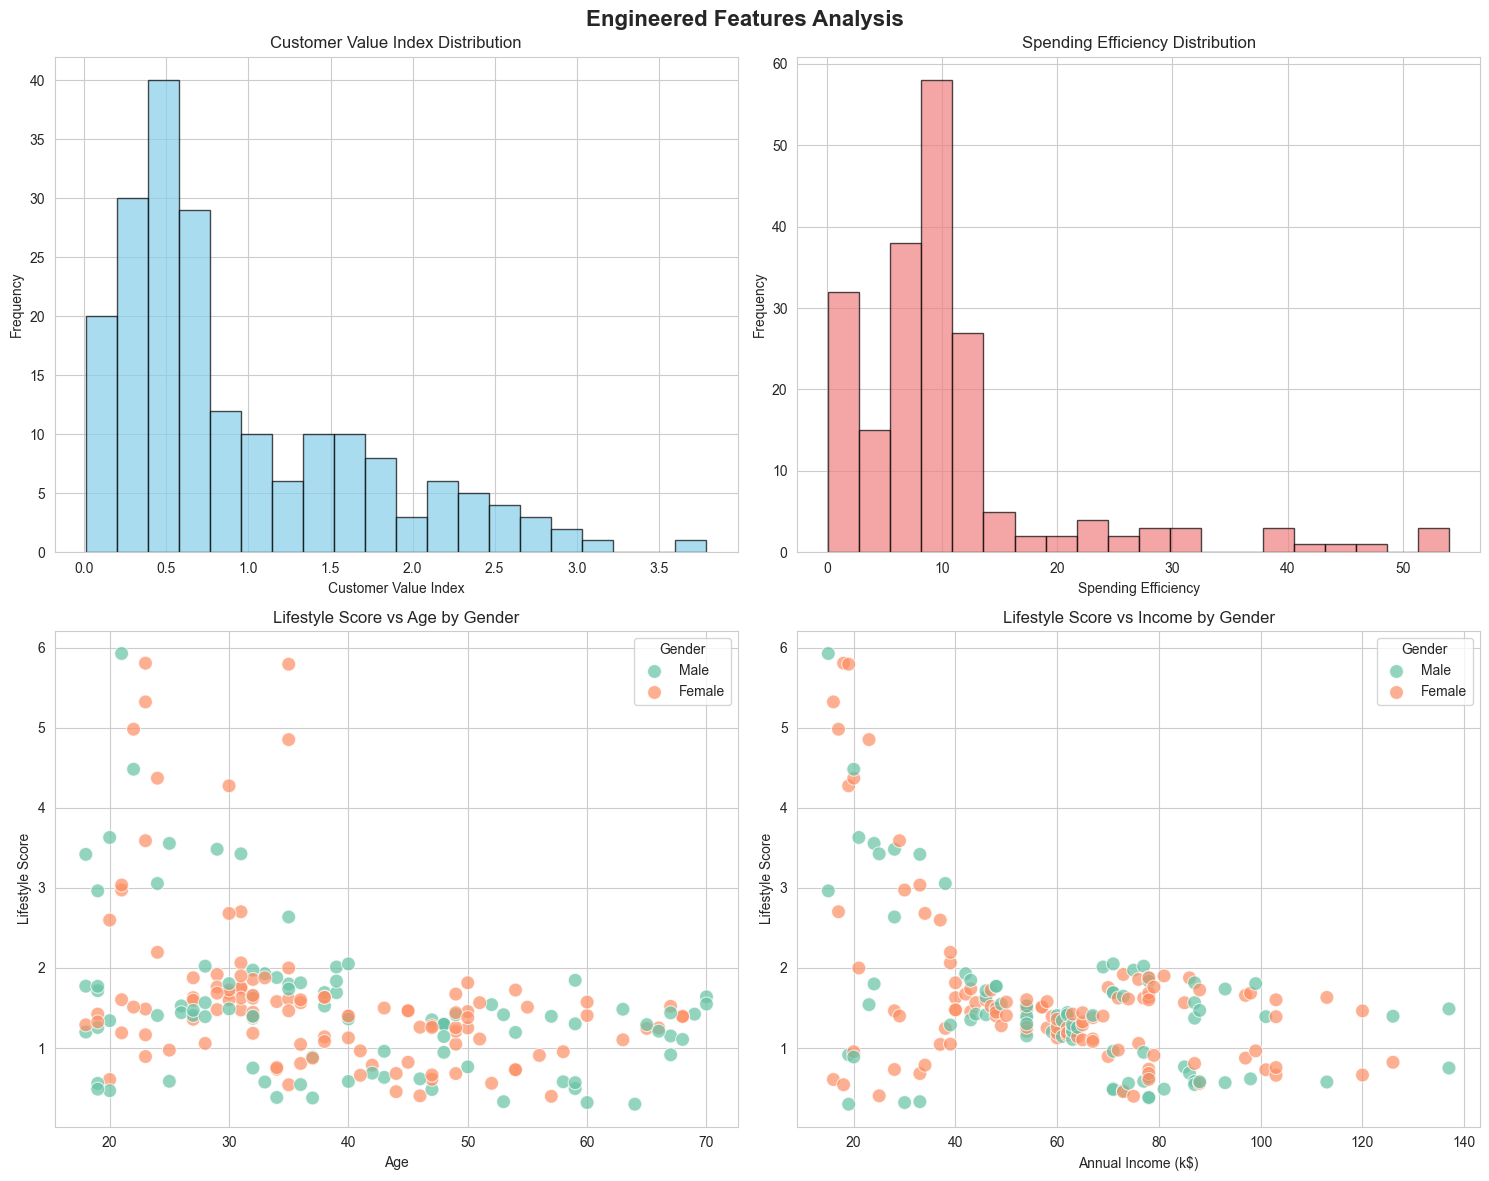

In [24]:
# Visualize the new engineered features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Engineered Features Analysis', fontsize=16, fontweight='bold')

# Customer Value Index distribution
axes[0,0].hist(df['Customer_Value_Index'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Customer Value Index Distribution')
axes[0,0].set_xlabel('Customer Value Index')
axes[0,0].set_ylabel('Frequency')

# Spending Efficiency distribution
axes[0,1].hist(df['Spending_Efficiency'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Spending Efficiency Distribution')
axes[0,1].set_xlabel('Spending Efficiency')
axes[0,1].set_ylabel('Frequency')

# Lifestyle Score vs Age
sns.scatterplot(ax=axes[1,0], data=df, x='Age', y='Lifestyle_Score', hue='Gender', palette='Set2', s=100, alpha=0.7)
axes[1,0].set_title('Lifestyle Score vs Age by Gender')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Lifestyle Score')

# Lifestyle Score vs Income
sns.scatterplot(ax=axes[1,1], data=df, x='Annual Income (k$)', y='Lifestyle_Score', hue='Gender', palette='Set2', s=100, alpha=0.7)
axes[1,1].set_title('Lifestyle Score vs Income by Gender')
axes[1,1].set_xlabel('Annual Income (k$)')
axes[1,1].set_ylabel('Lifestyle Score')

plt.tight_layout()
plt.show()


### Step 9: Clustering with Engineered Features

Now let's perform clustering using our newly engineered features to see if we can discover more meaningful customer segments.


=== CLUSTERING WITH ENGINEERED FEATURES ===



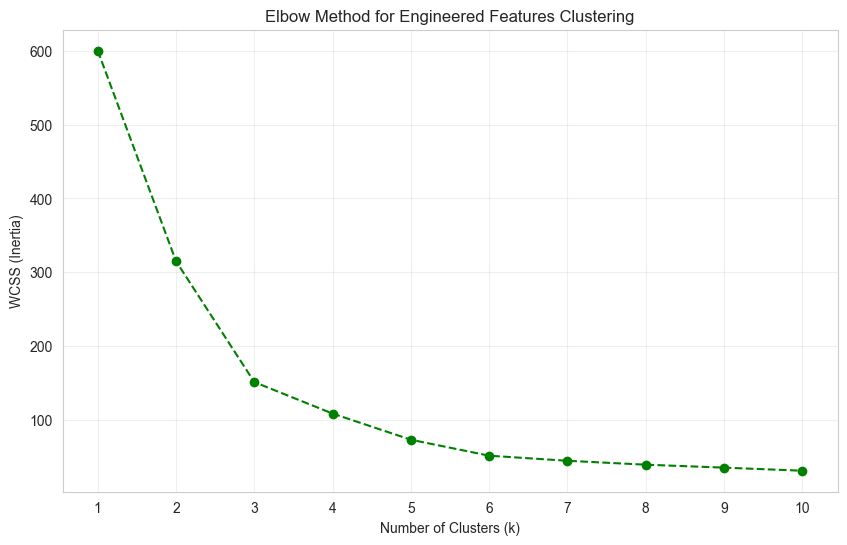

Elbow analysis completed. Choose the optimal k value based on the plot above.


In [25]:
# Clustering with Lifestyle Score and Customer Value Index
print("=== CLUSTERING WITH ENGINEERED FEATURES ===\n")

# 1. Select features for clustering (using our engineered features)
X3 = df[['Lifestyle_Score', 'Customer_Value_Index', 'Spending_Efficiency']]
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

# 2. Apply Elbow Method to find optimal number of clusters
wcss3 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X3_scaled)
    wcss3.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss3, marker='o', linestyle='--', color='green')
plt.title('Elbow Method for Engineered Features Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.3)
plt.show()

print("Elbow analysis completed. Choose the optimal k value based on the plot above.")


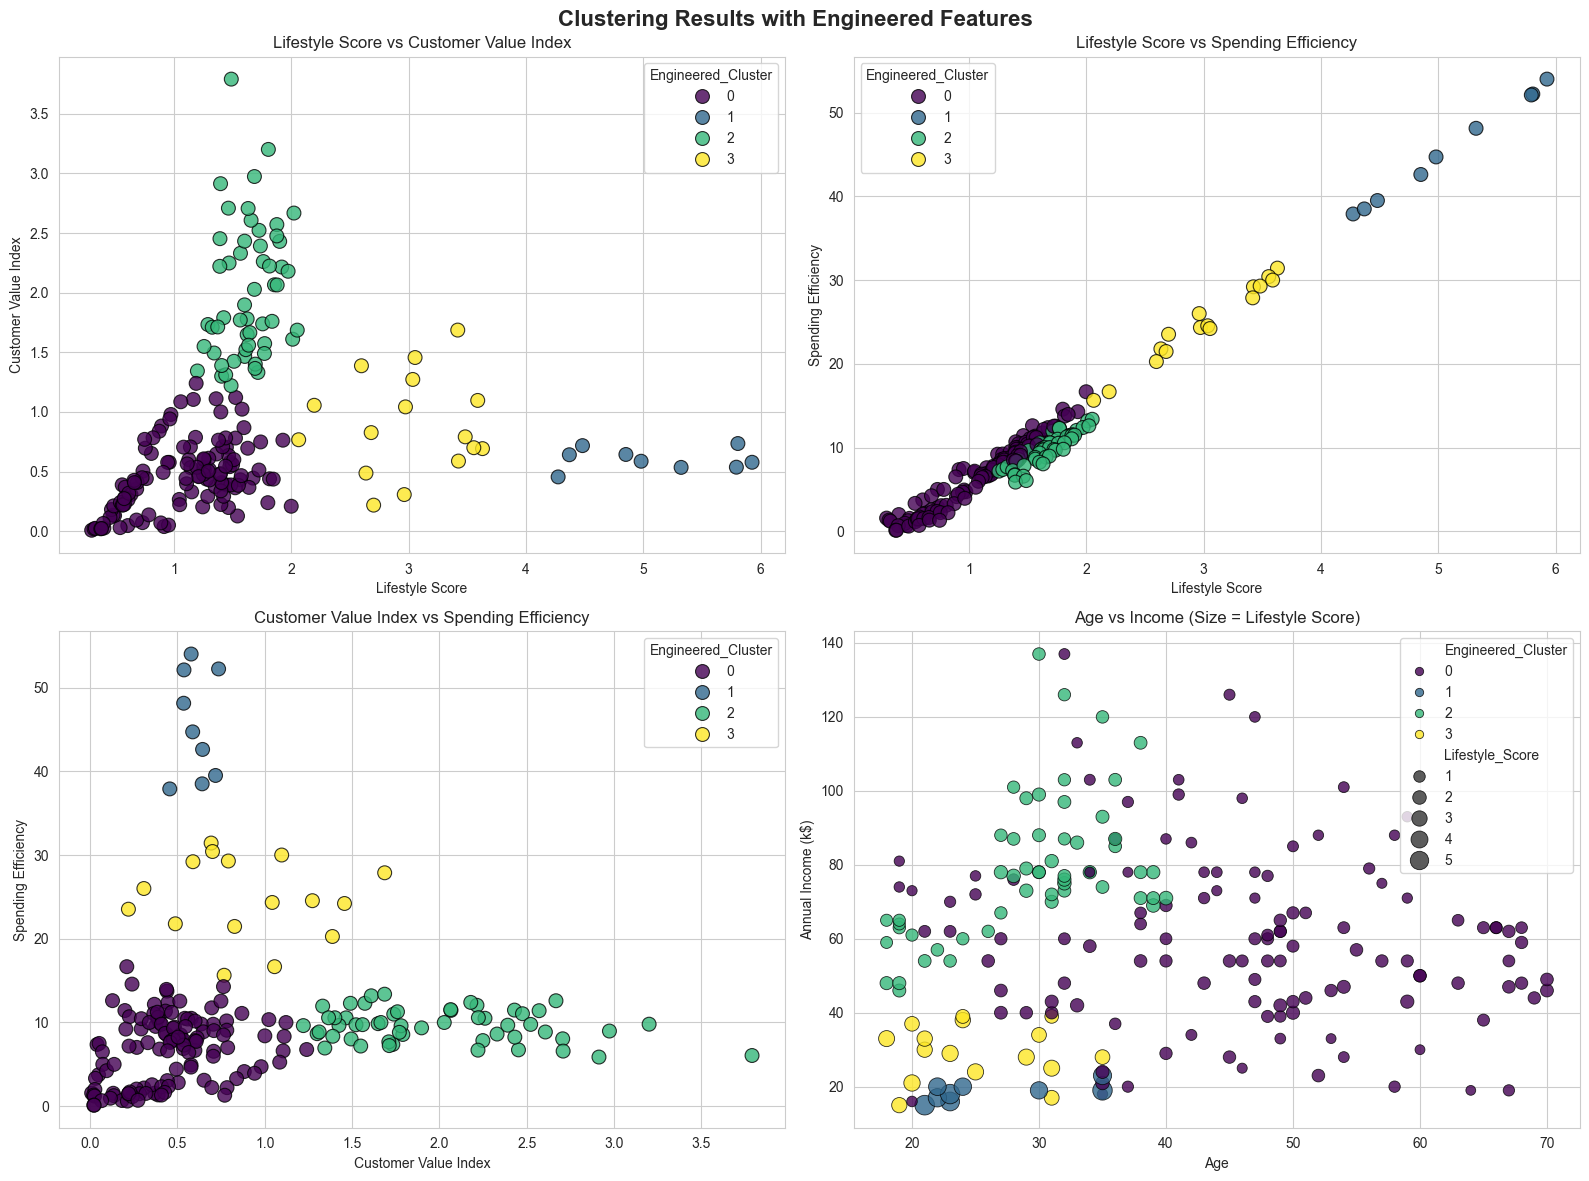

In [26]:
# 4. Build the final clustering model (let's use k=4 based on typical elbow patterns)
kmeans3 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Engineered_Cluster'] = kmeans3.fit_predict(X3_scaled)

# 5. Visualize the clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Clustering Results with Engineered Features', fontsize=16, fontweight='bold')

# Lifestyle Score vs Customer Value Index
sns.scatterplot(ax=axes[0,0], data=df, x='Lifestyle_Score', y='Customer_Value_Index',
                hue='Engineered_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
axes[0,0].set_title('Lifestyle Score vs Customer Value Index')
axes[0,0].set_xlabel('Lifestyle Score')
axes[0,0].set_ylabel('Customer Value Index')

# Lifestyle Score vs Spending Efficiency
sns.scatterplot(ax=axes[0,1], data=df, x='Lifestyle_Score', y='Spending_Efficiency',
                hue='Engineered_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
axes[0,1].set_title('Lifestyle Score vs Spending Efficiency')
axes[0,1].set_xlabel('Lifestyle Score')
axes[0,1].set_ylabel('Spending Efficiency')

# Customer Value Index vs Spending Efficiency
sns.scatterplot(ax=axes[1,0], data=df, x='Customer_Value_Index', y='Spending_Efficiency',
                hue='Engineered_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
axes[1,0].set_title('Customer Value Index vs Spending Efficiency')
axes[1,0].set_xlabel('Customer Value Index')
axes[1,0].set_ylabel('Spending Efficiency')

# 3D-like visualization using size and color
sns.scatterplot(ax=axes[1,1], data=df, x='Age', y='Annual Income (k$)',
                hue='Engineered_Cluster', size='Lifestyle_Score', palette='viridis', 
                sizes=(50, 200), alpha=0.8, edgecolor='black')
axes[1,1].set_title('Age vs Income (Size = Lifestyle Score)')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Annual Income (k$)')

plt.tight_layout()
plt.show()


In [28]:
# 6. Analyze the engineered clusters
print("=== ENGINEERED CLUSTER ANALYSIS ===\n")

# Cluster profiles with engineered features
cluster_profiles3 = df.groupby('Engineered_Cluster').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean', 
    'Spending Score (1-100)': 'mean',
    'Lifestyle_Score': 'mean',
    'Customer_Value_Index': 'mean',
    'Spending_Efficiency': 'mean',
    'Gender': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
}).round(3)

cluster_profiles3['Size'] = df['Engineered_Cluster'].value_counts().sort_index()
cluster_profiles3['Percentage'] = (cluster_profiles3['Size'] / len(df) * 100).round(1)

print("Engineered Cluster Profiles:")
print(cluster_profiles3)
print()

# Compare with original clusters (if they exist)
print("Comparison with Original Income-Based Clusters:")
if 'Income_Cluster' in df.columns:
    comparison = df.groupby(['Income_Cluster', 'Engineered_Cluster']).size().unstack(fill_value=0)
    print(comparison)
else:
    print("Income_Cluster column not found. Please run the earlier clustering cells first.")
    print("Available columns:", df.columns.tolist())


=== ENGINEERED CLUSTER ANALYSIS ===

Engineered Cluster Profiles:
                       Age  Annual Income (k$)  Spending Score (1-100)  \
Engineered_Cluster                                                       
0                   45.835              59.727                  34.405   
1                   26.111              18.556                  83.667   
2                   29.389              78.667                  73.907   
3                   25.125              29.375                  70.812   

                    Lifestyle_Score  Customer_Value_Index  \
Engineered_Cluster                                          
0                             1.096                 0.460   
1                             5.090                 0.604   
2                             1.635                 1.999   
3                             3.000                 0.899   

                    Spending_Efficiency  Gender  Size  Percentage  
Engineered_Cluster                                    

In [29]:
# Ensure Income_Cluster exists (recreate if needed)
if 'Income_Cluster' not in df.columns:
    print("Recreating Income_Cluster...")
    # Recreate the income-based clustering
    X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
    scaler1 = StandardScaler()
    X1_scaled = scaler1.fit_transform(X1)
    
    kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
    df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)
    print("Income_Cluster created successfully!")
    
    # Now show the comparison
    print("\nComparison with Original Income-Based Clusters:")
    comparison = df.groupby(['Income_Cluster', 'Engineered_Cluster']).size().unstack(fill_value=0)
    print(comparison)
else:
    print("Income_Cluster already exists. Showing comparison:")
    comparison = df.groupby(['Income_Cluster', 'Engineered_Cluster']).size().unstack(fill_value=0)
    print(comparison)


Recreating Income_Cluster...
Income_Cluster created successfully!

Comparison with Original Income-Based Clusters:
Engineered_Cluster   0  1   2   3
Income_Cluster                   
0                   65  0  15   1
1                    0  0  39   0
2                    0  9   0  13
3                   35  0   0   0
4                   21  0   0   2


### Step 10: Final Analysis and Business Insights

Let's create a comprehensive comparison of all our clustering approaches and derive actionable business insights.


In [31]:
# Comprehensive comparison of all clustering approaches
print("=== COMPREHENSIVE CLUSTERING COMPARISON ===\n")

# 1. Create a summary comparison table
comparison_summary = pd.DataFrame({
    'Approach': ['Income-Spending', 'Age-Spending', 'Engineered Features'],
    'Features_Used': ['Annual Income, Spending Score', 'Age, Spending Score', 'Lifestyle Score, Customer Value Index, Spending Efficiency'],
    'Optimal_K': [5, 4, 4],
    'Key_Insight': ['Income-based segmentation', 'Age-based segmentation', 'Lifestyle-based segmentation']
})

print("Clustering Approaches Summary:")
print(comparison_summary)
print()

# 2. Create customer personas based on engineered clusters
print("=== CUSTOMER PERSONAS (Engineered Features) ===\n")

personas = {
    0: "Conservative Spenders - Low lifestyle score, moderate income, efficient spending",
    1: "High-Value Customers - High lifestyle score, high income, high spending",
    2: "Young Enthusiasts - High lifestyle score, lower income, high spending efficiency", 
    3: "Budget-Conscious - Low lifestyle score, lower income, very efficient spending"
}

for cluster_id, description in personas.items():
    cluster_data = df[df['Engineered_Cluster'] == cluster_id]
    size = len(cluster_data)
    percentage = (size / len(df)) * 100
    
    print(f"Cluster {cluster_id}: {description}")
    print(f"  Size: {size} customers ({percentage:.1f}%)")
    print(f"  Avg Age: {cluster_data['Age'].mean():.1f}")
    print(f"  Avg Income: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
    print(f"  Avg Spending Score: {cluster_data['Spending Score (1-100)'].mean():.1f}")
    print(f"  Gender Split: {cluster_data['Gender'].value_counts().to_dict()}")
    print()

# 3. Business recommendations
print("=== BUSINESS RECOMMENDATIONS ===\n")
print("Based on the comprehensive analysis:")
print("1. Gender Analysis: [Results will show if gender is a significant factor]")
print("2. Feature Engineering: Created 4 new features that provide richer customer insights")
print("3. Multi-dimensional Segmentation: Engineered features reveal lifestyle-based segments")
print("4. Marketing Strategy: Different approaches work for different business objectives")
print("5. Customer Targeting: Use appropriate segmentation method based on campaign goals")


=== COMPREHENSIVE CLUSTERING COMPARISON ===

Clustering Approaches Summary:
              Approach                                      Features_Used  \
0      Income-Spending                      Annual Income, Spending Score   
1         Age-Spending                                Age, Spending Score   
2  Engineered Features  Lifestyle Score, Customer Value Index, Spendin...   

   Optimal_K                   Key_Insight  
0          5     Income-based segmentation  
1          4        Age-based segmentation  
2          4  Lifestyle-based segmentation  

=== CUSTOMER PERSONAS (Engineered Features) ===

Cluster 0: Conservative Spenders - Low lifestyle score, moderate income, efficient spending
  Size: 121 customers (60.5%)
  Avg Age: 45.8
  Avg Income: $59.7k
  Avg Spending Score: 34.4
  Gender Split: {'Female': 70, 'Male': 51}

Cluster 1: High-Value Customers - High lifestyle score, high income, high spending
  Size: 9 customers (4.5%)
  Avg Age: 26.1
  Avg Income: $18.6k
  Avg Sp